In [242]:
#### import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import PowerTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [243]:
data = pd.read_csv('cleaned_data.csv')

In [244]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244689 entries, 0 to 244688
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Artist(s)                 244689 non-null  object 
 1   song                      244689 non-null  object 
 2   text                      244689 non-null  object 
 3   emotion                   244689 non-null  object 
 4   Tempo                     244689 non-null  int64  
 5   Loudness (db)             244689 non-null  float64
 6   Energy                    244689 non-null  int64  
 7   Danceability              244689 non-null  int64  
 8   Positiveness              244689 non-null  int64  
 9   Speechiness               244689 non-null  int64  
 10  Liveness                  244689 non-null  int64  
 11  Acousticness              244689 non-null  int64  
 12  Instrumentalness          244689 non-null  int64  
 13  Good for Party            244689 non-null  i

In [245]:
# Fully numeric artist names
fully_numeric = data['Artist(s)'][data['Artist(s)'].str.fullmatch(r'\d+')]
print("🎤 Fully numeric artist names:", fully_numeric.unique().tolist())

🎤 Fully numeric artist names: []


In [246]:
data['Artist(s)'] = data['Artist(s)'].astype(str).str.lower().str.strip()
data['Artist(s)'] = data['Artist(s)'].str.replace(r'\$', 's', regex=True)
data['Artist(s)'] = data['Artist(s)'].str.replace('4', 'a')

In [247]:
data['Artist(s)'].value_counts()

Artist(s)
lab              1427
temm dogg         701
kora              670
shapeshifter      640
home brew         606
                 ... 
noah cyrus         25
yung gravy         25
eteeth             25
ziggy alberts      25
dragon             24
Name: count, Length: 3719, dtype: int64

In [248]:
data['Artist(s)'].isnull().sum()

np.int64(0)

In [249]:
data.dropna(inplace=True)
data.reset_index(drop = True, inplace=True)

In [250]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244689 entries, 0 to 244688
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Artist(s)                 244689 non-null  object 
 1   song                      244689 non-null  object 
 2   text                      244689 non-null  object 
 3   emotion                   244689 non-null  object 
 4   Tempo                     244689 non-null  int64  
 5   Loudness (db)             244689 non-null  float64
 6   Energy                    244689 non-null  int64  
 7   Danceability              244689 non-null  int64  
 8   Positiveness              244689 non-null  int64  
 9   Speechiness               244689 non-null  int64  
 10  Liveness                  244689 non-null  int64  
 11  Acousticness              244689 non-null  int64  
 12  Instrumentalness          244689 non-null  int64  
 13  Good for Party            244689 non-null  i

#### 4.2 **Power Transformer for Skewed Audio Features**

* we need to apply power transformer to the heavily skewed features like `instrumentalness`, `liveness`, `speechiness`, `loudness (db)` and `acousticness`.

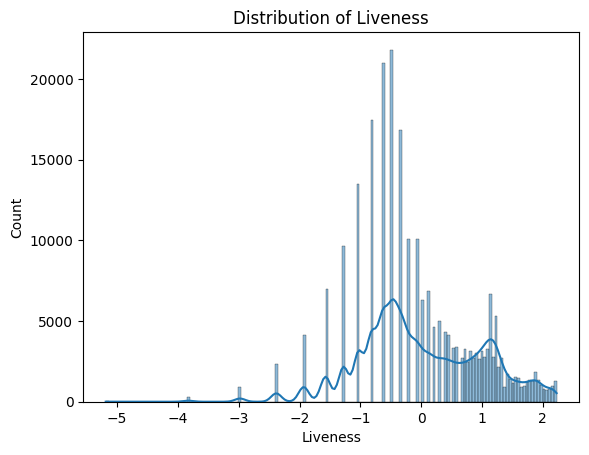

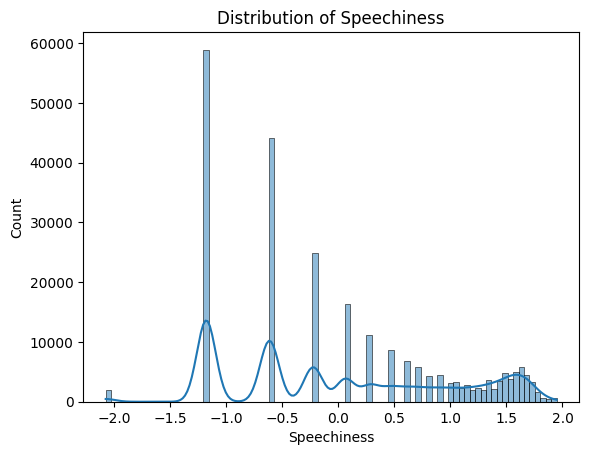

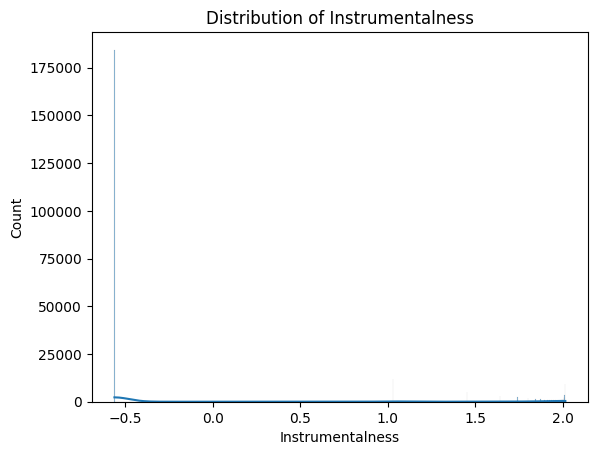

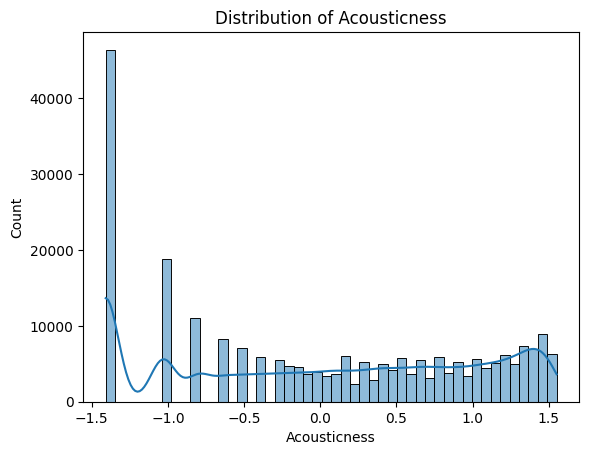

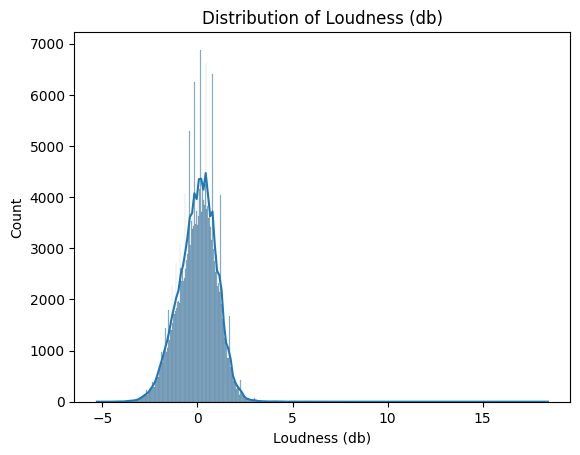

In [251]:
#### Applying power transformer to the skewed audio features.
pt = PowerTransformer(method='yeo-johnson')

cols_to_transform = ['Liveness', 'Speechiness', 'Instrumentalness', 'Acousticness', 'Loudness (db)']

scaled_audio = pt.fit_transform(data[cols_to_transform])
data[cols_to_transform] = scaled_audio

cols_to_transform = ['Liveness', 'Speechiness', 'Instrumentalness', 'Acousticness', 'Loudness (db)']
for feature in cols_to_transform:
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

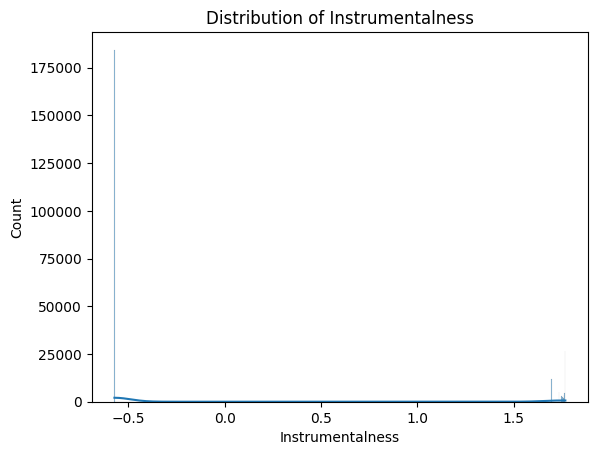

In [252]:
# apply log1p to instrumentalness first 
data[['Instrumentalness']] = np.log1p(data[['Instrumentalness']])

pt = PowerTransformer()
data[['Instrumentalness']] = pt.fit_transform(data[['Instrumentalness']])


sns.histplot(data['Instrumentalness'], kde=True)
plt.title(f'Distribution of Instrumentalness')
plt.show()

* Even after applying `log1p` and `power transformer` it doesn't change anything. so i will keep `Instrumentalness` as it is.

#### 4.3 **TF-IDF on text Columns**

In [253]:
### Applying tf-idf on text columns 
data['combined_text'] = (
    data['text'] + " " +
    data['emotion'] + " " +
    data['Genre_str'] + " " +
    data['Artist(s)']
)

tfidf = TfidfVectorizer(max_features=5000, stop_words='english') 
tfidf_matrix = tfidf.fit_transform(data['combined_text'])

In [254]:
similar_context_series = (
    data['Similar Artist 1']+ ' ' +
    data['Similar Artist 2']+ ' ' +
    data['Similar Artist 3']+ ' ' +
    data['Similar Song 1']+ ' ' +
    data['Similar Song 2']+ ' ' +
    data['Similar Song 3']
)

tfidf_similar = TfidfVectorizer(max_features=5000, stop_words="english")
similar_vectors = tfidf_similar.fit_transform(similar_context_series)

#### 4.4 **Combine TF-IDF & Scaled Audio features**

In [255]:
### Checking the shape od the tfidf matrix and scaled audio 
print(tfidf_matrix.shape[0], similar_vectors[0], scaled_audio.shape[0]) 

244689 <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (1, 5000)>
  Coords	Values
  (0, 4812)	0.5010175889894849
  (0, 115)	0.46817623652261225
  (0, 4945)	0.5211004095258948
  (0, 2314)	0.24540070650480814
  (0, 3268)	0.2728923607915389
  (0, 1734)	0.19618757425147942
  (0, 2299)	0.2497651406179686
  (0, 3619)	0.15060814446967896 244689


In [256]:
from scipy.sparse import hstack

# Combine into one final feature set for cosine similarity
final_matrix = hstack([tfidf_matrix, similar_vectors, scaled_audio])

In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244689 entries, 0 to 244688
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Artist(s)                 244689 non-null  object 
 1   song                      244689 non-null  object 
 2   text                      244689 non-null  object 
 3   emotion                   244689 non-null  object 
 4   Tempo                     244689 non-null  int64  
 5   Loudness (db)             244689 non-null  float64
 6   Energy                    244689 non-null  int64  
 7   Danceability              244689 non-null  int64  
 8   Positiveness              244689 non-null  int64  
 9   Speechiness               244689 non-null  float64
 10  Liveness                  244689 non-null  float64
 11  Acousticness              244689 non-null  float64
 12  Instrumentalness          244689 non-null  float64
 13  Good for Party            244689 non-null  i

#### **4.5 Handle User Query Input**

In [258]:
data['emotion'].unique()

array(['joy', 'anger', 'sadness', 'fear', 'surprise', 'love'],
      dtype=object)

In [259]:
import re
import spacy
nlp = spacy.load("en_core_web_sm")

# Define allowed dataset moods
available_moods = ['joy', 'sadness', 'anger', 'fear', 'surprise', 'love']

# Mapping user moods to dataset moods
mood_map = {
    'happy': 'joy',
    'calm': 'love',
    'relaxed': 'joy',
    'peaceful': 'joy',
    'romantic': 'love',
    'chill': 'joy',
    'energetic': 'surprise',
    'excited': 'surprise',
    'angry': 'anger',
    'depressed': 'sadness',
    'bored': 'sadness',
    'sad': 'sadness',
    'fearful': 'fear'
}

def extract_mood_artist_spacy(user_input, known_artists):
    doc = nlp(user_input.lower())
    user_input_lower = user_input.lower()

    # 1. Detect mood
    mood = ""
    for word in user_input_lower.split():
        if word in mood_map:
            mood = mood_map[word]
            break
        elif word in available_moods:
            mood = word
            break

    # 2. Detect artist
    artist = ""
    for known_artist in known_artists:
        pattern = r'\b' + re.escape(known_artist) + r'\b'
        if re.search(pattern, user_input_lower):
            artist = known_artist
            break

    return mood, artist


In [260]:
known_artists = data['Artist(s)'].str.lower().str.strip().unique().tolist()

user_input = "I'm feeling sad give me songs from mayday artist"
mood, artist = extract_mood_artist_spacy(user_input, known_artists)

print("Mapped mood:", mood)    
print("Artist:", artist) 

Mapped mood: sadness
Artist: mayday


In [261]:
# Fully numeric artist names
fully_numeric = data['Artist(s)'][data['Artist(s)'].str.fullmatch(r'\d+')]
print("🎤 Fully numeric artist names:", fully_numeric.unique().tolist())

🎤 Fully numeric artist names: []


In [262]:
data['Artist(s)'].unique()

array(['weird al yankovic', 'uicideboy', 'hed pe', ..., 'zz top',
       'mayday', 'sunset rollercoaster'], shape=(3719,), dtype=object)

In [263]:
data['Artist(s)'] = data['Artist(s)'].str.lower().str.strip()

#### **5.Building Recommendation Logic Using Cosine Similarity**

In [264]:
### Create Similar Song Dictionary
from collections import defaultdict

similar_song = defaultdict(dict)

for idx, row in data.iterrows():
    base_song = row['song']
    for i in range(1,4):
        sim_song = row[f'Similar Song {i}']
        sim_score = row[f'Similarity Score {i}']
        if pd.notnull(sim_song):
            similar_song[base_song][sim_song] = sim_score

In [265]:
data['Artist(s)'].value_counts()

Artist(s)
lab              1427
temm dogg         701
kora              670
shapeshifter      640
home brew         606
                 ... 
noah cyrus         25
yung gravy         25
eteeth             25
ziggy alberts      25
dragon             24
Name: count, Length: 3719, dtype: int64

In [267]:
data['Artist(s)'].unique()

array(['weird al yankovic', 'uicideboy', 'hed pe', ..., 'zz top',
       'mayday', 'sunset rollercoaster'], shape=(3719,), dtype=object)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack


def get_recommendations(user_input, top_n=5):
    # Extract mood and artist using spaCy
    mood, artist = extract_mood_artist_spacy(user_input, known_artists)

    # Detect activity 
    activity_map = {
        "party": "Good for Party",
        "reading": "Good for Work/Study",
        "study": "Good for Work/Study",
        "exercise": "Good for Exercise",
        "running": "Good for Running",
        "driving": "Good for Driving",
        "morning": "Good for Morning Routine",
        "relaxation": "Good for Relaxation/Yoga",
        "yoga": "Good for Relaxation/Yoga",
        "meditation": "Good for Relaxation/Yoga"
    }

    activity_col = ""
    for key, col in activity_map.items():
        if key in user_input.lower():
            activity_col = col
            break

    # TF-IDF vector for mood + input text
    search_text = f"{mood} {user_input}" if mood else user_input
    mood_vector = tfidf.transform([search_text])

    sim_context_input = artist if artist else mood or user_input
    sim_context_vector = tfidf_similar.transform([sim_context_input])
    
    avg_audio_vec = np.mean(scaled_audio, axis=0).reshape(1, -1)

    # 2. Stack them
    user_vector = hstack([mood_vector, sim_context_vector, avg_audio_vec])

    # 3. Compute similarity
    final_scores = cosine_similarity(user_vector, final_matrix).flatten()

    # Apply optional activity column filter
    if activity_col:
        activity_mask = data[activity_col] == 1
        final_scores *= activity_mask.astype(int).values

    # Boost scores of songs from the mentioned artist
    if artist:
        artist_mask = data['Artist(s)'].str.lower() == artist.lower()
        final_scores += artist_mask.astype(int).values * 0.25  

   # Get top N recommended songs (main DataFrame)
    top_indices = final_scores.argsort()[::-1][:top_n]
    results = data.iloc[top_indices][['song', 'Artist(s)', 'emotion', 'Genre_str']].copy()
    results['similarity_score'] = final_scores[top_indices]

    # Collect similar songs and artists from top recommendations
    all_similar_songs = set()
    all_similar_artists = set()

    for _, row in results.iterrows():
        song = row['song']
        original_artist = row['Artist(s)'].strip().lower()

        # Get similar song
        sim_song = list(similar_song.get(song, {}).keys())[:3]
        all_similar_songs.update(sim_song)

        # Genre-based similar artists
        song_genres = row['Genre_str'].split()
        genre_mask = data['Genre_str'].apply(lambda x: any(g in x.split() for g in song_genres))

        exclude_artists = {original_artist}
        if artist:
            exclude_artists.add(artist.strip().lower())

        candidate_artists = data[genre_mask]['Artist(s)'].str.lower().unique().tolist()
        filtered_artists = [a for a in candidate_artists if a not in exclude_artists]

        all_similar_artists.update(filtered_artists[:10])  # Collect more, filter later

    # Final top 5 unique similar songs and artists
    final_similar_songs = list(all_similar_songs)[:5]
    final_similar_artists = list(all_similar_artists)[:5]

    return results, final_similar_songs, final_similar_artists

In [308]:
user_input = "songs from 1991"
recommendations_df, similar_songs, similar_artists = get_recommendations(user_input)

print("\n Final Recommendations:")
print(recommendations_df)

print("\n Top 5 Similar Songs:")
for s in similar_songs:
    print(f" * {s}")

print("\n Top 5 Similar Artists:")
for a in similar_artists:
    print(f" * {a}")


 Final Recommendations:
                                   song          Artist(s) emotion  \
20761                        Love Songs  benjamin ingrosso     joy   
95830                       Modern Soul        james blake     joy   
229311  Songs About Me, Songs About You      uncle kracker     joy   
135233             Life Is for Learning        marvin gaye    love   
122054             Songs in the Kitchen          lee brice     joy   

                              Genre_str  similarity_score  
20761                               pop          0.293420  
95830   electronic dubstep experimental          0.284678  
229311                  rock pop hiphop          0.261165  
135233                    pop funk soul          0.254459  
122054                          country          0.252959  

 Top 5 Similar Songs:
 * Once Upon A Time
 * Goodbye
 * Urgency
 * Maybe Someday
 * Cross That Bridge

 Top 5 Similar Artists:
 * ashley mcbryde
 * astronautalis
 * l99l
 * hed pe
 * 2 live cre

In [296]:
data['Artist(s)'].value_counts()

Artist(s)
lab              1427
temm dogg         701
kora              670
shapeshifter      640
home brew         606
                 ... 
noah cyrus         25
yung gravy         25
eteeth             25
ziggy alberts      25
dragon             24
Name: count, Length: 3719, dtype: int64

In [289]:
data[data['Artist(s)'].str.lower() == 'eteeth'].shape[0]

25

* Instead of strictly relying on emotion labels (e.g., joy, sadness), similar songs are recommended based on lyrical similarity using TF-IDF and cosine similarity. This allows the system to capture songs whose lyrics align more closely with the user’s mood, even if the labeled emotion differs.